In [1]:
import pygad
import numpy as np
import pandas as pd

In [2]:
INPUT_DATA = "F:\Energy Engineering & University\seventh semester\Lessons\Renewable Energy\MAIN_DATA_Modified.csv"

df = pd.read_csv(INPUT_DATA)
df

,time,plastic,non metalic minerals,chemical,metal 1,metal 2,metal 3,total_demand,wind_output,pv_generation,Unnamed: 10,wind_output2,pv_generation2
0,1/1/2019 0:00,135.688187,24.862400,4.4480,2418.3337,3.140556e+03,37.654959,5761.543146,126.366629,0.0,NaN,126366.629092,-3.42
1,1/1/2019 1:00,135.678544,21.959600,4.3340,2443.9246,3.201572e+03,38.704569,5846.173713,99.922534,0.0,NaN,99922.534476,-3.42
2,1/1/2019 2:00,135.668901,21.833400,4.4480,2463.1177,3.614331e+03,39.754179,6279.153379,85.427511,0.0,NaN,85427.510802,-3.42
3,1/1/2019 3:00,135.659257,21.231190,4.2199,2447.1235,3.312838e+03,40.803789,5961.875436,80.026736,0.0,NaN,80026.735512,-3.42
4,1/1/2019 4:00,135.649614,19.298408,4.2199,2306.3739,3.043647e+03,41.853399,5551.042621,58.976087,0.0,NaN,58976.086888,-3.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12/31/2019 19:00,65.140600,11088.309349,12.5459,4484.7936,2.130000e-17,6232.766090,21883.555539,250.000000,0.0,NaN,250000.000000,-3.42
8756,12/31/2019 20:00,14.868100,11089.578645,10.7211,4683.1227,1.330000e-18,6232.368132,22030.658677,250.000000,0.0,NaN,250000.000000,-3.42
8757,12/31/2019 21:00,2.230300,11090.847941,11.4052,4823.8722,8.330000e-20,6231.970174,22160.325816,250.000000,0.0,NaN,250000.000000,-3.42
8758,12/31/2019 22:00,2.044500,11092.117237,17.1079,4759.8951,5.200000e-21,6231.572217,22102.736954,250.000000,0.0,NaN,250000.000000,-3.42


In [5]:
df = df[["total_demand", "wind_output", "pv_generation"]]
df

,total_demand,wind_output,pv_generation
0,5761.543146,126.366629,0.0
1,5846.173713,99.922534,0.0
2,6279.153379,85.427511,0.0
3,5961.875436,80.026736,0.0
4,5551.042621,58.976087,0.0
...,...,...,...
8755,21883.555539,250.000000,0.0
8756,22030.658677,250.000000,0.0
8757,22160.325816,250.000000,0.0
8758,22102.736954,250.000000,0.0


In [84]:
def calc_timeseries(
    arrays_count: float, wind_turbine_count: float, battery_count: float, flywheel_count: float, molten_salt_capacity: float
):
    solar_power = arrays_count * df["pv_generation"].to_numpy()
    wind_power = wind_turbine_count * df["wind_output"].to_numpy()
    renewable_power = wind_power + solar_power
    # Battery parameters
    capacity_per_battery = 400  # KWh
    max_charge_rate_per_battery = 78  # KW
    soc_max_per_battery = 360  # 90%
    soc_min_per_battery = 80  # 20%
    battery_capacity = battery_count * capacity_per_battery
    max_charge_rate_battery = battery_count * max_charge_rate_per_battery
    soc_max_battery = soc_max_per_battery * battery_count
    soc_min_battery = soc_min_per_battery * battery_count
    soc_init_battery = 200 * battery_count

    # Flywheel parameters # CHANGED!!!!!!!!
    capacity_per_flywheel = 400  # KWh 
    max_charge_rate_per_flywheel = 70  # KW 
    #efficiency_flywheel = 0.95  # 95% efficiency
    flywheel_capacity = flywheel_count * capacity_per_flywheel
    max_charge_rate_flywheel = flywheel_count * max_charge_rate_per_flywheel
    soc_max_flywheel = 360 * flywheel_count
    soc_min_flywheel = 40 * flywheel_count
    soc_init_flywheel = 200 * flywheel_count

    # Molten Salt parameters # CHANGED!!!!!!!!
    capacity_per_molten_salt = 3954020.4  # KWh (large capacity for long-duration storage)
    max_charge_rate_per_molten_salt = 665660  # KW (slower charge/discharge rate)
    #efficiency_molten_salt = 0.85  # 85% efficiency
    molten_salt_capacity_total = molten_salt_capacity
    max_charge_rate_molten_salt = max_charge_rate_per_molten_salt
    soc_max_molten_salt = molten_salt_capacity_total * 0.9
    soc_min_molten_salt = 0
    soc_init_molten_salt = 0

    demand = df["total_demand"].to_numpy()

    soc_arr_battery = np.zeros(len(df))
    soc_arr_flywheel = np.zeros(len(df))  # CHANGED!!!!!!!!
    soc_arr_molten_salt = np.zeros(len(df))  # CHANGED!!!!!!!!
    grid_sell_arr = np.zeros(len(df))
    grid_buy_arr = np.zeros(len(df))
    for t in range(len(df) - 1):
        last_soc_battery = soc_arr_battery[t - 1] if t != 0 else soc_init_battery
        last_soc_flywheel = soc_arr_flywheel[t - 1] if t != 0 else soc_init_flywheel  # CHANGED!!!!!!!!
        last_soc_molten_salt = soc_arr_molten_salt[t - 1] if t != 0 else soc_init_molten_salt  # CHANGED!!!!!!!!
        if renewable_power[t] >= demand[t]:
            total_excess_energy = renewable_power[t] - demand[t]
            # Charge flywheel first (faster response) # CHANGED!!!!!!!!
            flywheel_charge = min(total_excess_energy, max_charge_rate_flywheel, soc_max_flywheel - last_soc_flywheel)
            soc_arr_flywheel[t] = last_soc_flywheel + flywheel_charge

            # Charge battery with remaining excess energy
            remaining_excess = total_excess_energy - flywheel_charge
            battery_charge = min(remaining_excess, max_charge_rate_battery, soc_max_battery - last_soc_battery)
            soc_arr_battery[t] = last_soc_battery + battery_charge

            # Charge molten salt with remaining excess energy # CHANGED!!!!!!!!
            remaining_excess -= battery_charge
            molten_salt_charge = min(remaining_excess, max_charge_rate_molten_salt, soc_max_molten_salt - last_soc_molten_salt)
            soc_arr_molten_salt[t] = last_soc_molten_salt + molten_salt_charge

            # Sell any remaining excess to the grid
            grid_sell_arr[t] = remaining_excess - molten_salt_charge
        else:
            total_deficiency_energy = demand[t] - renewable_power[t]

            # Discharge flywheel first (faster response)
            flywheel_discharge = min(total_deficiency_energy, max_charge_rate_flywheel, last_soc_flywheel - soc_min_flywheel)
            soc_arr_flywheel[t] = last_soc_flywheel - flywheel_discharge

            # Discharge battery with remaining deficiency
            remaining_deficiency = total_deficiency_energy - flywheel_discharge
            battery_discharge = min(remaining_deficiency, max_charge_rate_battery, last_soc_battery - soc_min_battery)
            soc_arr_battery[t] = last_soc_battery - battery_discharge

            # Discharge molten salt with remaining deficiency # CHANGED!!!!!!!!
            remaining_deficiency -= battery_discharge
            molten_salt_discharge = min(remaining_deficiency, max_charge_rate_molten_salt, last_soc_molten_salt - soc_min_molten_salt)
            soc_arr_molten_salt[t] = last_soc_molten_salt - molten_salt_discharge

            # Buy any remaining deficiency from the grid
            grid_buy_arr[t] = remaining_deficiency - molten_salt_discharge

    return pd.DataFrame({
        "solar_power": solar_power,
        "wind_power": wind_power,
        "buy_grid": grid_buy_arr,
        "sell_grid": grid_sell_arr,
        "soc_battery": soc_arr_battery,
        "soc_flywheel": soc_arr_flywheel,
        "soc_molten_salt": soc_arr_molten_salt,  # CHANGED!!!!!!!!
        "demand": df["total_demand"].to_numpy(),
    })


calc_timeseries(10, 100, 20, 20, 250000).to_csv("sample.csv")

In [92]:
SOLAR_GENE_INDEX = 0
WIND_GENE_INDEX = 1
BATTERY_GENE_INDEX = 2
FLYWHEEL_GENE_INDEX = 3
MOLTEN_SALT_GENE_INDEX = 4  # CHANGED!!!!!!!!

SOLAR_MIN = 0
SOLAR_MAX = 10000
BATTERY_MIN = 0
BATTERY_MAX = 3500
FLYWHEEL_MIN = 0
FLYWHEEL_MAX = 1000
MOLTEN_SALT_MIN = 0  # CHANGED!!!!!!!!
MOLTEN_SALT_MAX = 1000000  # CHANGED!!!!!!!!

WT_MIN = 0
WT_MAX = 2900


def fitness_function(_, solution, __):
    electricity_buy_cost = 0.004
    electricity_sell_income = 0.02

    num_years = 1
    solar_coef = solution[SOLAR_GENE_INDEX]
    capex_per_solar = 13800
    opex_per_solar = 195.5
    solar_count = np.floor(SOLAR_MIN + solar_coef * (SOLAR_MAX - SOLAR_MIN))

    wind_turbine_coef = solution[WIND_GENE_INDEX]
    capex_per_wind_turbine = 21500
    opex_per_wind_turbine = 7500
    wind_turbine_count = np.floor(WT_MIN + wind_turbine_coef * (WT_MAX - WT_MIN))

    capex_per_battery = 15220
    opex_per_battery = 3076
    battery_size_coef = solution[BATTERY_GENE_INDEX]
    battery_count = np.floor(
        BATTERY_MIN + battery_size_coef * (BATTERY_MAX - BATTERY_MIN)
    )

    capex_per_flywheel = 36000
    opex_per_flywheel = 2228
    flywheel_size_coef = solution[FLYWHEEL_GENE_INDEX]
    flywheel_count = np.floor(FLYWHEEL_MIN + flywheel_size_coef * (FLYWHEEL_MAX - FLYWHEEL_MIN))

    # Molten Salt costs # CHANGED!!!!!!!!
    capex_per_molten_salt = 732000000  # Higher CAPEX due to large-scale storage
    opex_per_molten_salt = 50000000  # Higher OPEX due to maintenance
    molten_salt_size_coef = solution[MOLTEN_SALT_GENE_INDEX]
    molten_salt_capacity = np.floor(MOLTEN_SALT_MIN + molten_salt_size_coef * (MOLTEN_SALT_MAX - MOLTEN_SALT_MIN))

    result = calc_timeseries(
        battery_count=battery_count,
        arrays_count=solar_count,
        wind_turbine_count=wind_turbine_coef,
        flywheel_count=flywheel_count,
        molten_salt_capacity=molten_salt_capacity,  # CHANGED!!!!!!!!
    )

    battery_cost = (capex_per_battery + opex_per_battery * num_years) * battery_count
    solar_cost = (capex_per_solar + opex_per_solar * num_years) * solar_count
    wind_cost = (
        capex_per_wind_turbine + opex_per_wind_turbine * num_years
    ) * wind_turbine_count
    flywheel_cost = (capex_per_flywheel + opex_per_flywheel * num_years) * flywheel_count
    molten_salt_cost = (capex_per_molten_salt + opex_per_molten_salt * num_years) * molten_salt_capacity  # CHANGED!!!!!!!!
    grid_cost = np.sum(result["buy_grid"]) * electricity_buy_cost
    sell_income = np.sum(result["sell_grid"]) * electricity_sell_income

    # Fitness function with penalty for extreme values # @@@@@@@
    '''penalty = 0
    if molten_salt_capacity > MOLTEN_SALT_MAX * 0.9:  # Penalize solutions with too much molten salt
        penalty += 1e6
    if flywheel_count < FLYWHEEL_MAX * 0.9:  # Penalize solutions with too less flywheels
        penalty += 1e6
    if battery_count > BATTERY_MAX * 0.9:  # Penalize solutions with too many batteries
        penalty += 1e6'''

    return -1 * (battery_cost + solar_cost + wind_cost + flywheel_cost + molten_salt_cost + grid_cost) + sell_income #- penalty # CHANGED!!!!!!!!


In [93]:
ga_instance = pygad.GA(
    num_generations=25,
    num_parents_mating=4,
    fitness_func=fitness_function,
    sol_per_pop=12,
    num_genes=5,
    init_range_low=0,
    init_range_high=1,
    gene_space={"low": 0, "high": 1.0},
    parent_selection_type="sss",
    keep_parents=2,
    crossover_type="single_point",
    mutation_type="adaptive",
    mutation_percent_genes=[10, 5],
)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pygad\pygad.py:770: UserWarning: The percentage of genes to mutate (10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate ({mutation_percent_genes[idx]}) resulted in selecting ({mutation_num_genes[idx]}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pygad\pygad.py:770: UserWarning: The percentage of genes to mutate (5) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any 

In [94]:
ga_instance.run()

In [95]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
solution, solution_fitness

(array([0.01698163, 0.08742939, 0.02210839, 0.10932749, 0.01622351]),
 np.float64(-12686401834666.342))

In [96]:
solar_count = np.floor(SOLAR_MIN + solution[SOLAR_GENE_INDEX] * (SOLAR_MAX - SOLAR_MIN))
wind_turbine_count = np.floor(WT_MIN + solution[WIND_GENE_INDEX] * (WT_MAX - WT_MIN))
battery_count = np.floor(
    BATTERY_MIN + solution[BATTERY_GENE_INDEX] * (BATTERY_MAX - BATTERY_MIN)
)
flywheel_count = np.floor(FLYWHEEL_MIN + solution[FLYWHEEL_GENE_INDEX] * (FLYWHEEL_MAX - FLYWHEEL_MIN))  # CHANGED!!!!!!!!
molten_salt_capacity = np.floor(MOLTEN_SALT_MIN + solution[MOLTEN_SALT_GENE_INDEX] * (MOLTEN_SALT_MAX - MOLTEN_SALT_MIN))  # CHANGED!!!!!!!!


solar_count, wind_turbine_count, battery_count, flywheel_count, molten_salt_capacity

(np.float64(169.0),
 np.float64(253.0),
 np.float64(77.0),
 np.float64(109.0),
 np.float64(16223.0))

In [97]:
# Calculate the result with the best solution
result = calc_timeseries(
    arrays_count=solar_count,
    wind_turbine_count=wind_turbine_count,
    battery_count=battery_count,
    flywheel_count=flywheel_count,  # CHANGED!!!!!!!!
    molten_salt_capacity=molten_salt_capacity,  # CHANGED!!!!!!!!
)
result


,solar_power,wind_power,buy_grid,sell_grid,soc_battery,soc_flywheel,soc_molten_salt,demand
0,0.0,31970.757160,0.0,0.000000,21406.00000,29430.0,12573.214014,5761.543146
1,0.0,25280.401222,0.0,3770.741524,27412.00000,37060.0,14600.700000,5846.173713
2,0.0,21613.160233,0.0,12846.006853,27720.00000,39240.0,14600.700000,6279.153379
3,0.0,20246.764085,0.0,14284.888649,27720.00000,39240.0,14600.700000,5961.875436
4,0.0,14920.949983,0.0,9369.907362,27720.00000,39240.0,14600.700000,5551.042621
...,...,...,...,...,...,...,...,...
8755,0.0,63250.000000,0.0,27730.444461,20477.58638,27250.0,14600.700000,21883.555539
8756,0.0,63250.000000,0.0,27583.341323,26483.58638,34880.0,14600.700000,22030.658677
8757,0.0,63250.000000,0.0,35493.260564,27720.00000,39240.0,14600.700000,22160.325816
8758,0.0,63250.000000,0.0,41147.263046,27720.00000,39240.0,14600.700000,22102.736954


<Axes: >

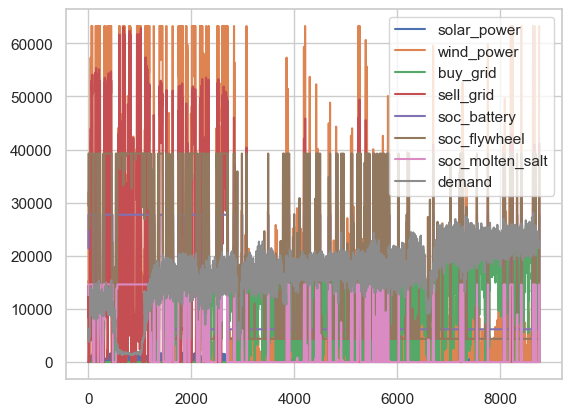

In [98]:
result.plot()

In [99]:
# Save result to CSV
result.to_csv("optimized_microgrid_schedule_with_molten_salt.csv", index=False)  # CHANGED!!!!!!!!

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns


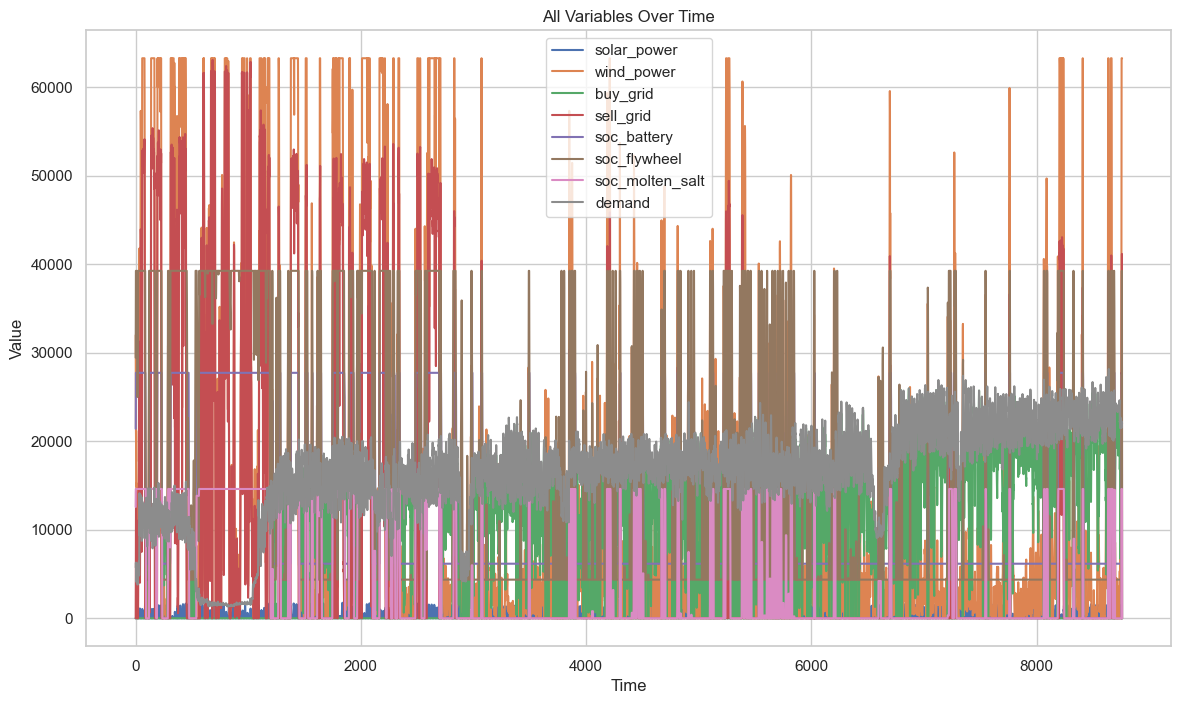

In [101]:
# Plotting
sns.set(style="whitegrid")

# Plot all variables
plt.figure(figsize=(14, 8))
for column in result.columns:
    plt.plot(result[column], label=column)
plt.title("All Variables Over Time")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

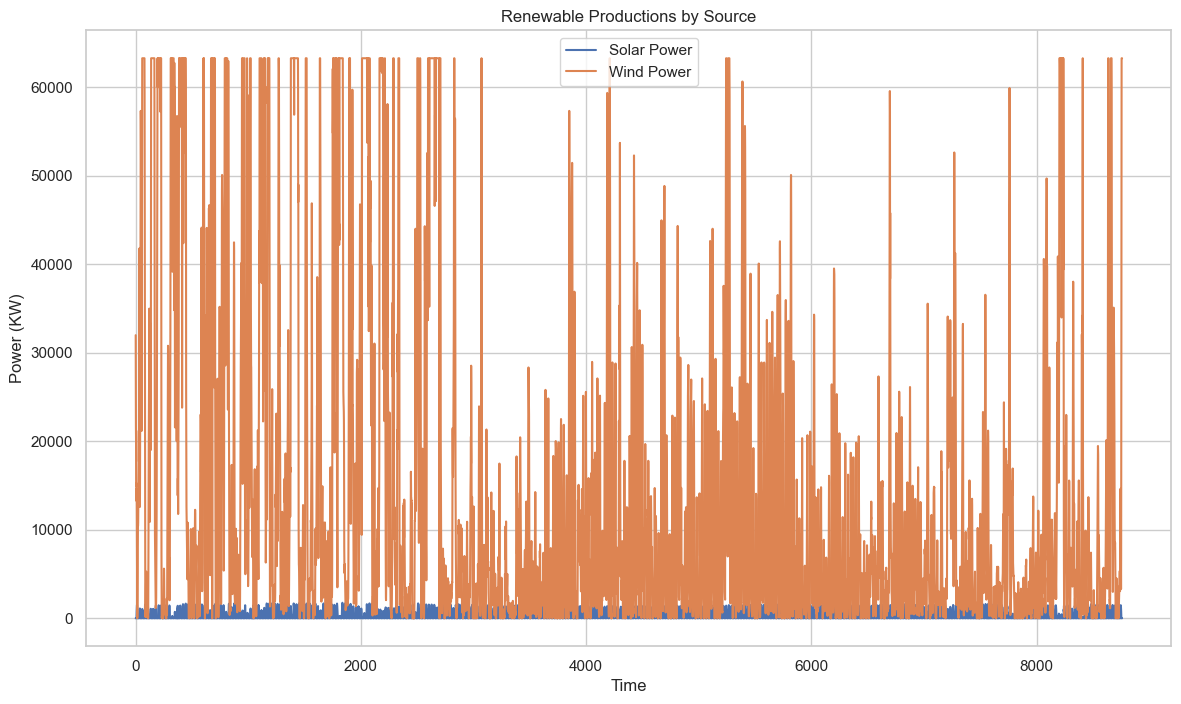

In [102]:
# Plot renewable productions by source
plt.figure(figsize=(14, 8))
plt.plot(result["solar_power"], label="Solar Power")
plt.plot(result["wind_power"], label="Wind Power")
plt.title("Renewable Productions by Source")
plt.xlabel("Time")
plt.ylabel("Power (KW)")
plt.legend()
plt.show()

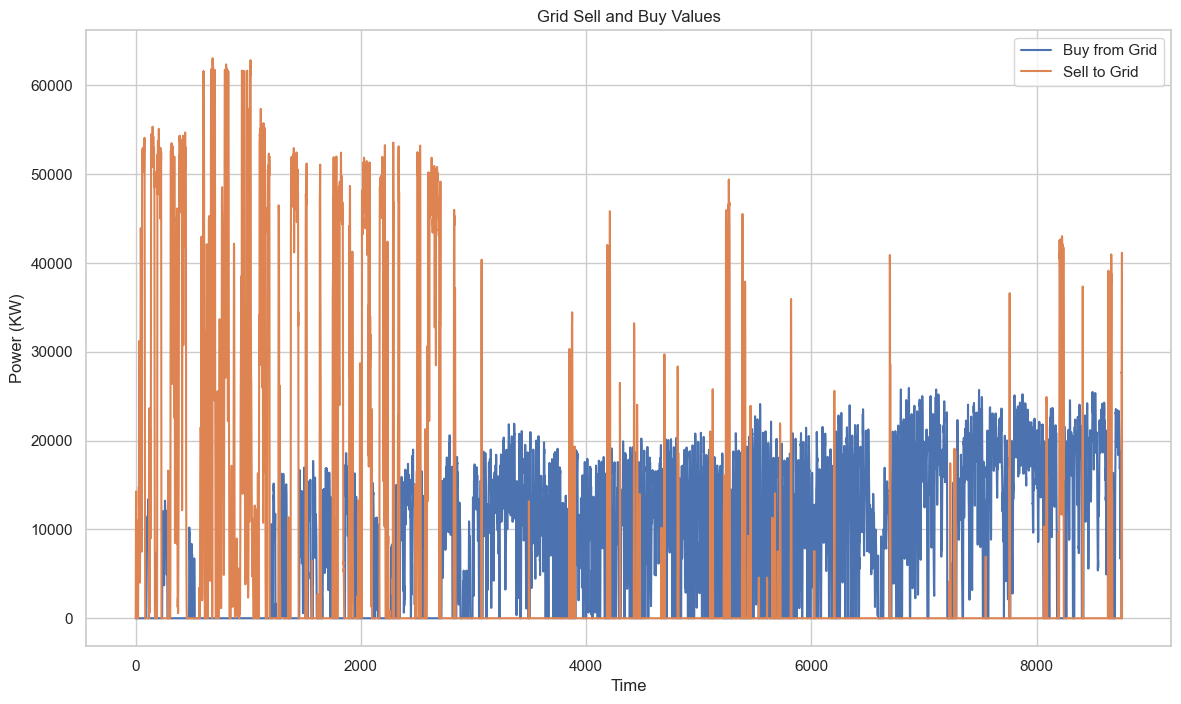

In [103]:
# Plot grid sell and buy values
plt.figure(figsize=(14, 8))
plt.plot(result["buy_grid"], label="Buy from Grid")
plt.plot(result["sell_grid"], label="Sell to Grid")
plt.title("Grid Sell and Buy Values")
plt.xlabel("Time")
plt.ylabel("Power (KW)")
plt.legend()
plt.show()

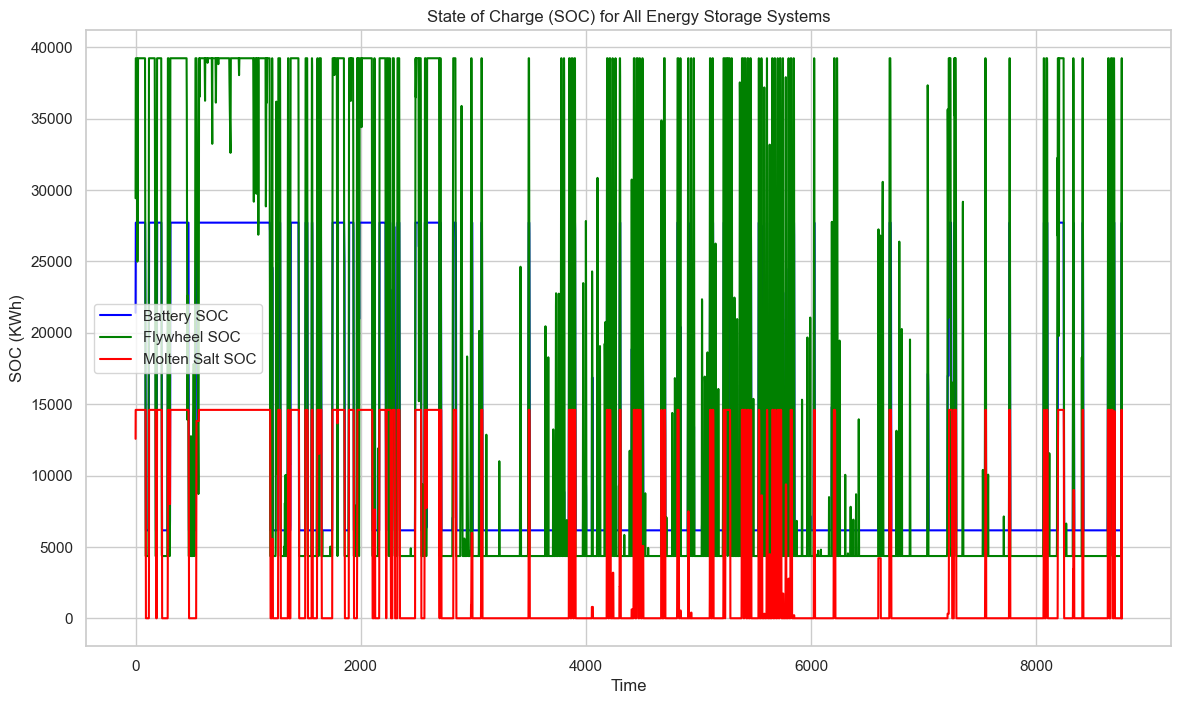

In [104]:
# Plot SOC for all ESSs
plt.figure(figsize=(14, 8))

# Plot Battery SOC
plt.plot(result["soc_battery"], label="Battery SOC", color="blue")

# Plot Flywheel SOC
plt.plot(result["soc_flywheel"], label="Flywheel SOC", color="green")

# Plot Molten Salt SOC
plt.plot(result["soc_molten_salt"], label="Molten Salt SOC", color="red")

# Add labels, title, and legend
plt.title("State of Charge (SOC) for All Energy Storage Systems")
plt.xlabel("Time")
plt.ylabel("SOC (KWh)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_11028\3905078623.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result['time'] = pd.date_range(start='1/1/2019', periods=len(result), freq='H')
C:\Users\Asus\AppData\Local\Temp\ipykernel_11028\3905078623.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = result.resample('M', on='time').mean()


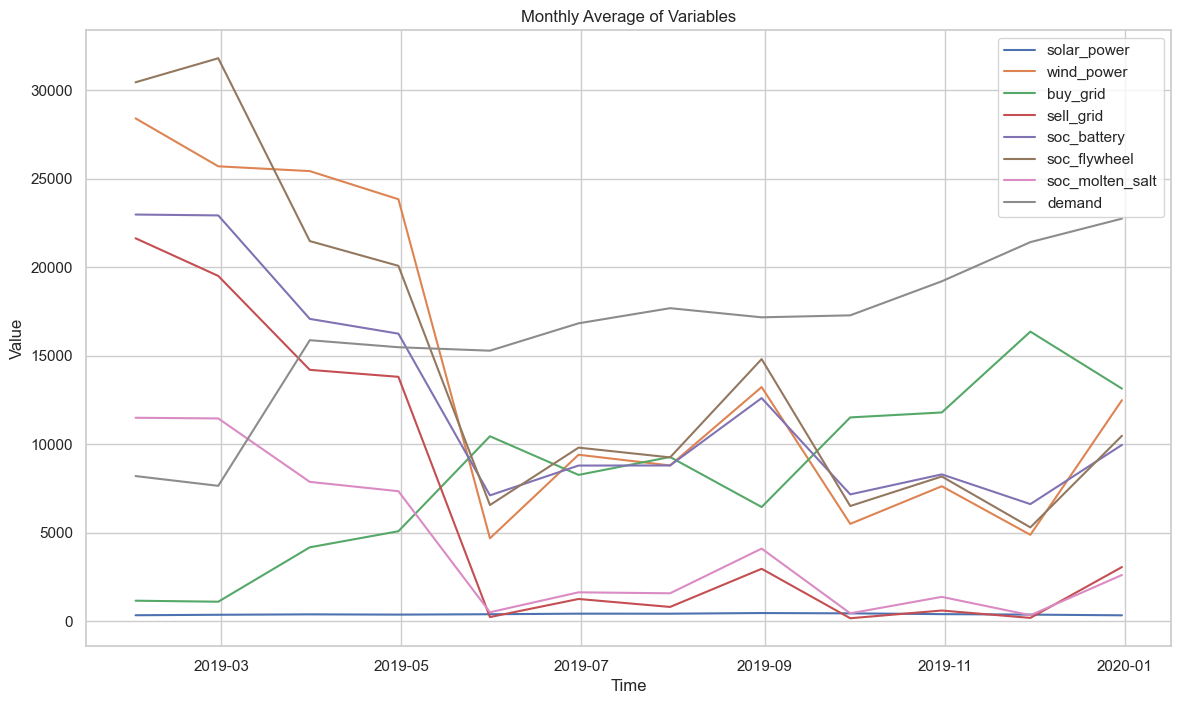

In [105]:
# Plot each month
result['time'] = pd.date_range(start='1/1/2019', periods=len(result), freq='H')
monthly_data = result.resample('M', on='time').mean()
plt.figure(figsize=(14, 8))
for column in monthly_data.columns:
    if column != 'time':
        plt.plot(monthly_data.index, monthly_data[column], label=column)
plt.title("Monthly Average of Variables")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()